In [92]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [93]:
train_df = pd.read_csv(r'C:\Users\zyh\Desktop\train.csv')
test_df = pd.read_csv(r'C:\Users\zyh\Desktop\test.csv')
combine_df = pd.concat([train_df,test_df])

In [94]:
#Title
combine_df['Title'] = combine_df['Name'].apply(lambda x: x.split(', ')[1]).apply(lambda x: x.split('.')[0])
combine_df['Title'] = combine_df['Title'].replace(['Don','Dona', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir','Dr'],'Mr')
combine_df['Title'] = combine_df['Title'].replace(['Mlle','Ms'], 'Miss')
combine_df['Title'] = combine_df['Title'].replace(['the Countess','Mme','Lady','Dr'], 'Mrs')
df = pd.get_dummies(combine_df['Title'],prefix='Title')
combine_df = pd.concat([combine_df,df],axis=1)

#Name_length
combine_df['Name_Len'] = combine_df['Name'].apply(lambda x: len(x))
combine_df['Name_Len'] = pd.qcut(combine_df['Name_Len'],5)

#Dead_female_family & Survive_male_family
combine_df['Surname'] = combine_df['Name'].apply(lambda x:x.split(',')[0])
dead_female_surname = list(set(combine_df[(combine_df.Sex=='female') & (combine_df.Age>=12)
                              & (combine_df.Survived==0) & ((combine_df.Parch>0) | (combine_df.SibSp > 0))]['Surname'].values))
survive_male_surname = list(set(combine_df[(combine_df.Sex=='male') & (combine_df.Age>=12)
                              & (combine_df.Survived==1) & ((combine_df.Parch>0) | (combine_df.SibSp > 0))]['Surname'].values))
combine_df['Dead_female_family'] = np.where(combine_df['Surname'].isin(dead_female_surname),0,1)
combine_df['Survive_male_family'] = np.where(combine_df['Surname'].isin(survive_male_surname),0,1)
combine_df = combine_df.drop(['Name','Surname'],axis=1)

In [95]:
#Age & isChild
group = combine_df.groupby(['Title', 'Pclass'])['Age']
combine_df['Age'] = group.transform(lambda x: x.fillna(x.median()))
combine_df = combine_df.drop('Title',axis=1)

combine_df['IsChild'] = np.where(combine_df['Age']<=12,1,0)
combine_df['Age'] = pd.cut(combine_df['Age'],5)
combine_df = combine_df.drop('Age',axis=1)

In [96]:
#FamilySize
combine_df['FamilySize'] = np.where(combine_df['SibSp']+combine_df['Parch']==0, 'Alone',
                                    np.where(combine_df['SibSp']+combine_df['Parch']<=3, 'Small', 'Big'))
df = pd.get_dummies(combine_df['FamilySize'],prefix='FamilySize')
combine_df = pd.concat([combine_df,df],axis=1).drop(['SibSp','Parch','FamilySize'],axis=1)

In [97]:
#Ticket
combine_df['Ticket_Lett'] = combine_df['Ticket'].apply(lambda x: str(x)[0])
combine_df['Ticket_Lett'] = combine_df['Ticket_Lett'].apply(lambda x: str(x))

combine_df['High_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['1', '2', 'P']),1,0)
combine_df['Low_Survival_Ticket'] = np.where(combine_df['Ticket_Lett'].isin(['A','W','3','7']),1,0)
combine_df = combine_df.drop(['Ticket','Ticket_Lett'],axis=1)

In [98]:
#Embarked
combine_df = combine_df.drop('Embarked',axis=1)

In [99]:
#Cabin
combine_df['Cabin_isNull'] = np.where(combine_df['Cabin'].isnull(),0,1)
combine_df = combine_df.drop('Cabin',axis=1)

In [100]:
#PClass
df = pd.get_dummies(combine_df['Pclass'],prefix='Pclass')
combine_df = pd.concat([combine_df,df],axis=1).drop('Pclass',axis=1)

In [101]:
#Sex
df = pd.get_dummies(combine_df['Sex'],prefix='Sex')
combine_df = pd.concat([combine_df,df],axis=1).drop('Sex',axis=1)

In [102]:
#Fare
combine_df['Fare'].fillna(combine_df['Fare'].dropna().median(),inplace=True)
combine_df['Low_Fare'] = np.where(combine_df['Fare']<=8.662,1,0)
combine_df['High_Fare'] = np.where(combine_df['Fare']>=26,1,0)
combine_df = combine_df.drop('Fare',axis=1)

In [103]:
features = combine_df.drop(["PassengerId","Survived"], axis=1).columns
le = LabelEncoder()
for feature in features:
    le = le.fit(combine_df[feature])
    combine_df[feature] = le.transform(combine_df[feature])

In [104]:
X_all = combine_df.iloc[:891,:].drop(["PassengerId","Survived"], axis=1)
Y_all = combine_df.iloc[:891,:]["Survived"]
X_test = combine_df.iloc[891:,:].drop(["PassengerId","Survived"], axis=1)

In [105]:
logreg = LogisticRegression()
score = 0
for i in range(0,10):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all, Y_all, test_size=num_test)
    logreg.fit(X_train, Y_train)
    Y_test = logreg.predict(X_test)
    acc_log = round(logreg.score(X_cv, Y_cv) * 100, 2)
    score+=acc_log
score/10

86.088000000000008

In [106]:
coeff_df = pd.DataFrame()
coeff_df['Feature'] = features
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
5,Dead_female_family,3.051658
0,Title_Master,1.283906
7,IsChild,0.752376
8,FamilySize_Alone,0.735237
17,Sex_female,0.630976
13,Cabin_isNull,0.531839
20,High_Fare,0.492373
3,Title_Mrs,0.470914
11,High_Survival_Ticket,0.281418
10,FamilySize_Small,0.269076


In [107]:
svc = SVC()
score = 0
for i in range(0,10):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all, Y_all, test_size=num_test)
    svc.fit(X_train, Y_train)
    Y_test = logreg.predict(X_test)
    acc_svc = round(svc.score(X_cv, Y_cv) * 100, 2)
    score+=acc_svc
score/10

85.921999999999997

In [108]:
knn = KNeighborsClassifier(n_neighbors = 3)
score = 0
for i in range(0,10):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all, Y_all, test_size=num_test)
    knn.fit(X_train, Y_train)
    Y_test = logreg.predict(X_test)
    acc_knn = round(knn.score(X_cv, Y_cv) * 100, 2)
    score+=acc_knn
score/10

84.579999999999998

In [109]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
score = 0
for i in range(0,10):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all, Y_all, test_size=num_test)
    decision_tree.fit(X_train, Y_train)
    Y_test = decision_tree.predict(X_test)
    acc_decision_tree = round(decision_tree.score(X_cv, Y_cv) * 100, 2)
    score+=acc_decision_tree
score/10

86.424000000000007

In [110]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
score = 0
for i in range(0,50):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all, Y_all, test_size=num_test)
    random_forest.fit(X_train, Y_train)
    Y_test = random_forest.predict(X_test)
    acc_random_forest = round(random_forest.score(X_cv, Y_cv) * 100, 2)
    score+=acc_random_forest
score/50

85.329000000000008

In [111]:
#XGBoost
xgb = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
score = 0
for i in range(0,50):
    num_test = 0.20
    X_train, X_cv, Y_train, Y_cv = train_test_split(X_all, Y_all, test_size=num_test)
    xgb.fit(X_train, Y_train)
    Y_test = xgb.predict(X_test)
    acc_xgb = round(xgb.score(X_cv, Y_cv) * 100, 2)
    score+=acc_xgb
score/50

87.88760000000002

In [112]:
xgb.fit(X_all, Y_all)
Y_test = xgb.predict(X_test).astype(int)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_test
    })
submission.to_csv(r'C:\Users\zyh\Desktop\submission.csv', index=False)

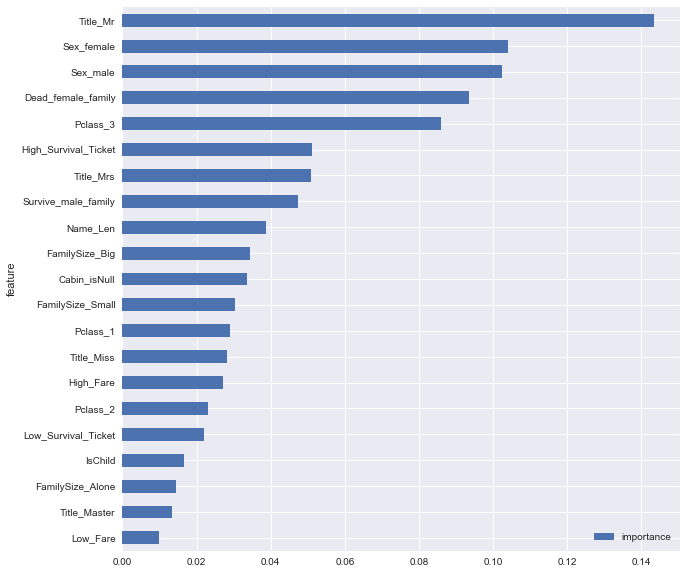

In [113]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = features
feature_importance['importance'] = random_forest.feature_importances_
feature_importance.sort_values(by='importance', ascending=True, inplace=True)
feature_importance.set_index('feature', inplace=True)
feature_importance.plot(kind='barh', figsize=(10, 10))